# 3 Charge Selection

Fisrt, we use the result of the Notebook 2. We will use the `cleaned_leptons_df` Output DataFrame as the input DF for this notebook.

Success: uproot, vector, and awkward are loaded.
--- START OF H -> 4l ANALYSIS (Real Data) ---
Attempting to load a maximum of 300000 events per file...
Diagnostic: Read 300000 events. Number of Muons in the first event: 3
Success: 708402 leptons loaded from DoubleMuon_B.
Diagnostic: Read 300000 events. Number of Muons in the first event: 3
Success: 744875 leptons loaded from DoubleMuon_C.
Diagnostic: Read 300000 events. Number of Electrons in the first event: 0
Success: 368352 leptons loaded from DoubleElectron_B.
Diagnostic: Read 300000 events. Number of Electrons in the first event: 2
Success: 370768 leptons loaded from DoubleElectron_C.

Total loading successful. Total of 2192397 leptons ready for analysis.
-> pT cut > 5.0 GeV: 214026 leptons rejected.
-> |eta| cut < 2.5: 8629 leptons rejected (after pT).
-> Isolation Cut (iso < 0.3): 779749 leptons rejected (after pT and eta).

Total leptons after quality cuts: 1189993

--- MASS CORRECTION: 284241 negative masses forced to 0.0 ---

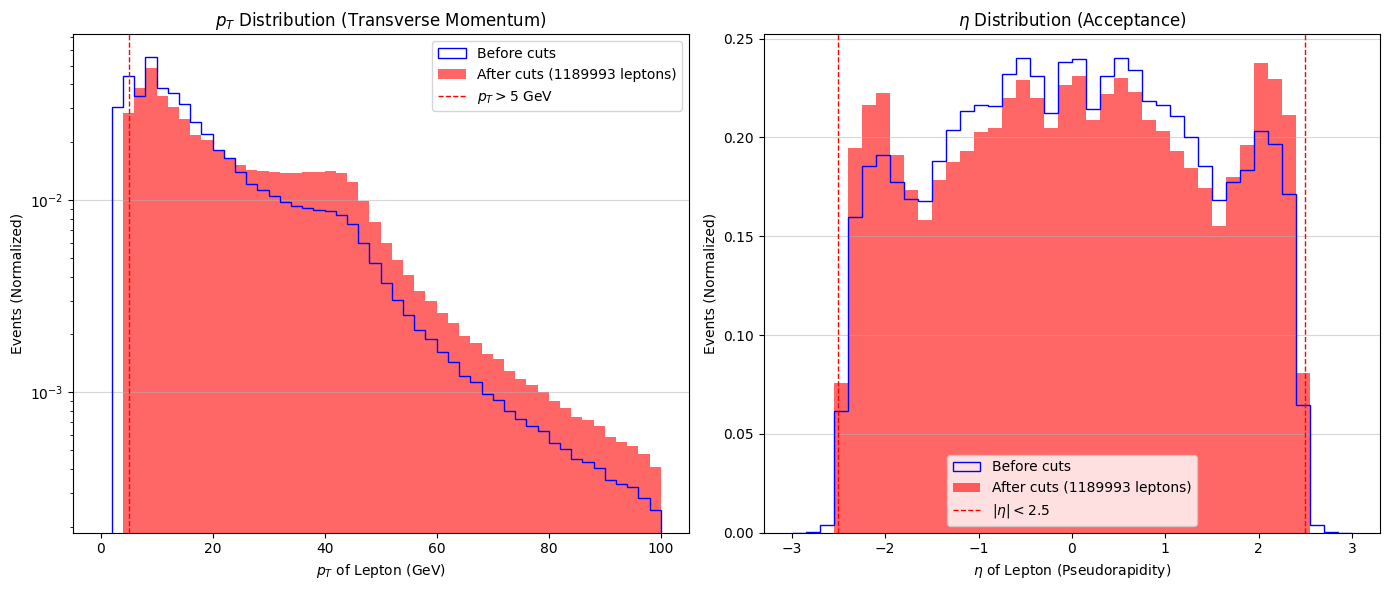


--- STATUS: Quality cuts applied and verified. ---

Preview of filtered leptons (ready for combination):
    event_id         pt  charge  flavor         iso
0  599701946  30.409157       1      13 -999.000000
1  599701946  33.029179       1      13 -999.000000
2  599721392  10.679796       1      13 -999.000000
3  599895577  56.900928       1      13    0.006498
4  599895577  34.670677      -1      13    0.000000


In [2]:
%run ../2_Leptons_Selection/main.ipynb

## Grouping lepton

The goal of this function is to filter a DataFrame of individual leptons down to events that satisfy two core physics criteria:
1.  **Lepton Count:** Exactly four leptons.
2.  **Net Charge:** A total net charge of zero ($\sum q = 0$).

It also extracts a **diagnostic dataset** of all events that pass the 4-lepton cut *before* the charge cut.


> [!TIP]
> The lv (Lorenz Vector) column in the df produce unexpeceted bug when apying filters and other Pandas operations. So we remove it temporarily before filtering and recontruct after.

In [ ]:
def group_leptons_by_event_with_diagnostic_data(df):
    """
    Groups leptons by event, filtering to keep only events that meet the H -> 4l criteria
    (4 leptons + zero net charge) AND returns the 'Before Charge Cut' data for diagnostics.
    """
    print("\nStep 5: Applying event-level filtering (4 leptons and zero net charge)...")
    initial_events = df['event_id'].nunique()
    
    # STEP 1: TEMPORARILY REMOVE THE VECTOR COLUMN FOR SAFE FILTERING
    # We create a safe version of the DataFrame without the toxic 'lv' column
    kinematic_df = df.drop(columns=['lv']) if 'lv' in df.columns else df
    
    # STEP 2: GROUP AND FILTER BASED ON BASE COLUMNS
    event_groups = kinematic_df.groupby('event_id')
    event_counts = event_groups.size()
    event_net_charge = event_groups['charge'].sum()
    
    # STEP3: DIAGNOSTIC DATA GATHERING
    # Calculate the set of IDs for ALL 4-lepton events BEFORE the charge cut
    four_lepton_events_ids = event_counts[event_counts == 4].index 
    #Since the index of event_counts is the event_id, this returns a pandas Index object containing a list of all event IDs that satisfy the 4-lepton requirement.
    
    # DataFrame for the 'Before Charge Cut' plot data
    # This contains all events with 4 leptons, regardless of charge sum.
    df_before_charge_cut = kinematic_df[kinematic_df['event_id'].isin(four_lepton_events_ids)].reset_index(drop=True)

    # STEP 4: FINAL FILTERING
    zero_net_charge_events = event_net_charge[event_net_charge == 0].index
    
    # Combine the 4-lepton requirement and the zero net charge requirement
    valid_event_ids = four_lepton_events_ids.intersection(zero_net_charge_events)
    
    # Select final condidates
    df_4l = kinematic_df[kinematic_df['event_id'].isin(valid_event_ids)].reset_index(drop=True)

    # STEP 5: REGENERATE AND RE-ATTACH THE VECTOR COLUMN to the FINAL DF
    if not df_4l.empty and 'lv' in df.columns:
        new_vector_array = vector.array({
            "pt": df_4l['pt'], "eta": df_4l["eta"], 
            "phi": df_4l["phi"], "mass": df_4l["mass"]
        })
        df_4l['lv'] = new_vector_array
        print("Success: 'lv' column safely regenerated and re-attached to final candidates.")

    #DEBUG OUTPUTS
    final_events = df_4l['event_id'].nunique()
    print(f"-> Initial Events: {initial_events}")
    print(f"-> Final Events (4l, net charge 0): {final_events}")
    print(f"-> Total Leptons remaining: {len(df_4l)}")

    # Return the FINAL data and the DIAGNOSTIC data
    return df_4l, df_before_charge_cut

The next function will plot the net charge distribution of 4-lepton events selected to verify the charge selection is 0 after the cuts. The output is a normalized plot, we display the probability and not the raw number of events for each charge.

In [ ]:
def plot_charge_diagnostics(df_before_charge_cut, df_after_charge_cut):
    """
    Plots the net charge distribution of 4-lepton events to verify the charge selection.
    
    df_before_charge_cut: DataFrame containing ALL 4-lepton events (regardless of charge).
    df_after_charge_cut: DataFrame containing only 4-lepton events with net charge = 0.
    """
    
    # 1. Calculate Net Charge for the 'Before' set (all 4-lepton events)
    # This ensures we plot the full distribution before the cut.
    events_before = df_before_charge_cut.groupby('event_id')['charge'].sum()
    
    # 2. Calculate Net Charge for the 'After' set (only zero-charge events)
    events_after = df_after_charge_cut.groupby('event_id')['charge'].sum()
    
    # 3. Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Plot the full distribution (Before Cut)
    ax.hist(events_before, bins=9, range=(-4.5, 4.5), histtype='step', 
            label=f'All 4-Lepton Events ({len(events_before)} total)', 
            color='blue', density=True, linewidth=2)

    # Plot the filtered distribution (After Cut - should be only one bin)
    ax.hist(events_after, bins=9, range=(-4.5, 4.5), histtype='bar', alpha=0.6, 
            label=f'Selected 4l Candidates ({len(events_after)})', 
            color='red', density=True)
    
    ax.set_xticks(np.arange(-4, 5, 2)) # Set ticks at -4, -2, 0, 2, 4
    ax.set_xlabel('Sum of Lepton Charges per Event')
    ax.set_ylabel('Events (Normalized)')
    ax.set_title('Net Charge Distribution for 4-Lepton Events')
    ax.legend()
    ax.grid(axis='y', alpha=0.5)
    
    plt.show()


Step 5: Applying event-level filtering (4 leptons and zero net charge)...
Success: 'lv' column safely regenerated and re-attached to final candidates.
-> Initial Events: 258221
-> Final Events (4l, net charge 0): 822
-> Total Leptons remaining: 3288

--- STATUS: Event selection complete ---

Preview of H -> 4l candidate leptons:


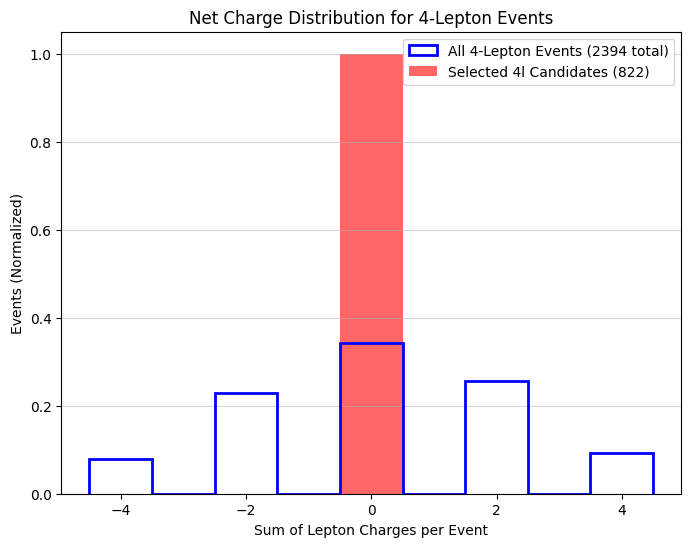

In [ ]:
four_lepton_candidates_df, all_four_leptons_df = group_leptons_by_event_with_diagnostic_data(cleaned_leptons_df)

print("\n--- STATUS: Event selection complete ---")

if not four_lepton_candidates_df.empty:
    print("\nPreview of H -> 4l candidate leptons:")
    
    plot_charge_diagnostics(all_four_leptons_df, four_lepton_candidates_df)

The symmetry observed in the net charge distribution is a direct consequence of fundamental **symmetries in physics**, primarily **Charge Conjugation (C-symmetry)** in the dominant background processes.

### Charge Conjugation (C-Symmetry)

C-symmetry states that the laws of physics are the same if every particle is replaced by its corresponding antiparticle. This flips the sign of all charges.

The primary background processes that produce the 4-lepton candidates are mediated by the **Strong** and **Electromagnetic** forces, which **conserve C-symmetry**.

If a process results in a net charge of **$+Q$**, the C-conjugate process (replacing all particles with antiparticles) will occur with **equal probability** and will result in a net charge of **$-Q$**.

### Conclusion

The symmetry provides a good diagnostic: it confirms that the **background** processes are physically balanced, allowing our $\sum Q = 0$ cut to cleanly select the small, unique sample from the **neutral** Higgs decay.

## Variables exposed:
- `four_lepton_candidates_df` : DataFrame containing only 4-lepton events with net charge = 0.
- `all_four_leptons_df` : DataFrame containing ALL 4-lepton events (regardless of charge).